# **1. Introdução**
O Índice Nacional de Preços ao Consumidor Amplo (IPCA) é a principal métrica de inflação no Brasil, calculado mensalmente pelo IBGE. Este trabalho tem como objetivo analisar a série temporal do IPCA (1991-2025), identificar padrões (tendência, sazonalidade) e construir um modelo de previsão utilizando técnicas de séries temporais.

**Justificativa:**

*   O IPCA é crucial para políticas econômicas e investimentos.

*   Permite avaliar a eficácia de medidas de controle de inflação.

*   Dados disponíveis em longa série histórica, ideal para modelagem.




# 2. Análise Exploratória Inicial

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [83]:
# Carregar os dados
df = pd.read_csv('/content/ipca.csv', parse_dates=['Data'], dayfirst=True)
df.set_index('Data', inplace=True)
df.columns = ['IPCA']


In [84]:
# Estatísticas descritivas
print("Estatísticas Descritivas:\n", df.describe())
print("\nAnos cobertos:", df.index.year.min(), "-", df.index.year.max())

Estatísticas Descritivas:
              IPCA
count  411.000000
mean     3.268029
std      8.747375
min     -1.280000
25%      0.090000
50%      0.650000
75%      1.250000
max     52.150000

Anos cobertos: 1991 - 2025


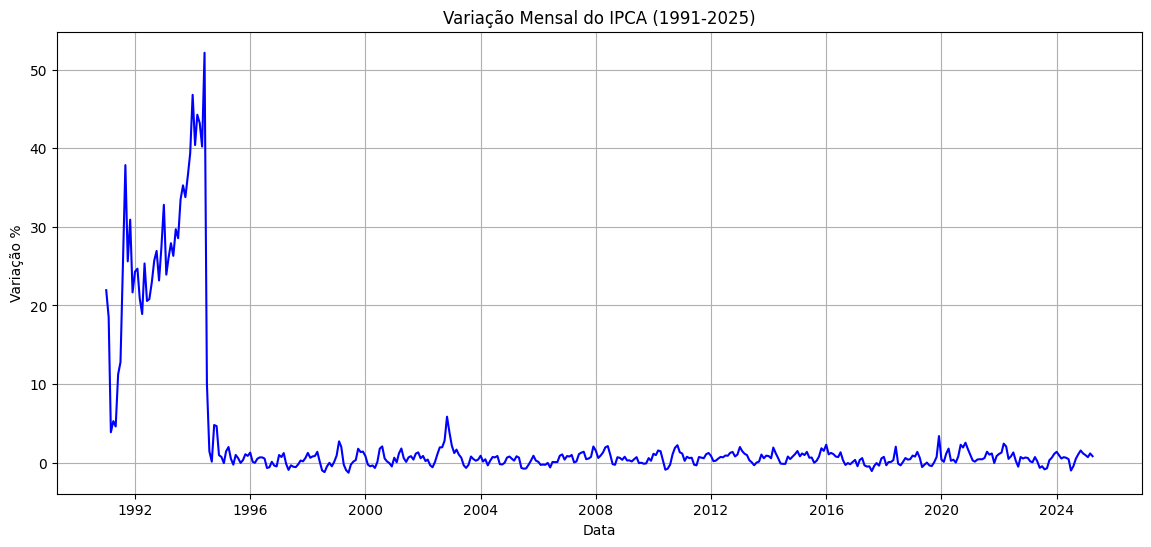

In [85]:
# Visualização inicial
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['IPCA'], color='blue')
plt.title('Variação Mensal do IPCA (1991-2025)')
plt.xlabel('Data')
plt.ylabel('Variação %')
plt.grid(True)
plt.show()

# 3. Análise de Componentes

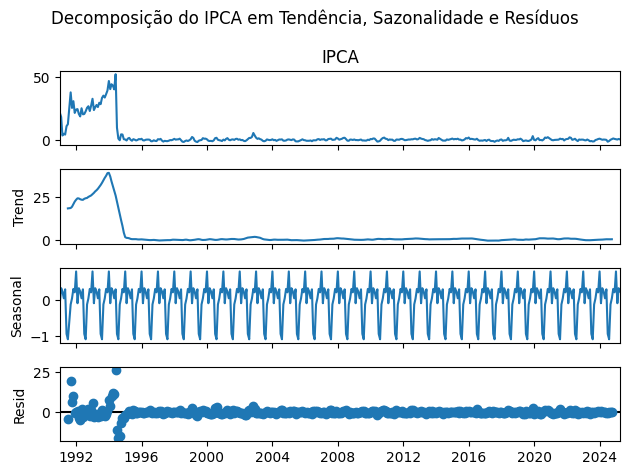

In [86]:
#Decomposição da Série Temporal
decomposition = seasonal_decompose(df['IPCA'], model='additive', period=12)
decomposition.plot()
plt.suptitle('Decomposição do IPCA em Tendência, Sazonalidade e Resíduos')
plt.tight_layout()
plt.show()

In [87]:
#Teste de Estacionariedade
def test_stationarity(series):
    result = adfuller(series.dropna())
    print('Estatística ADF:', result[0])
    print('p-valor:', result[1])
    print('Valores Críticos:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    return result[1] > 0.05

print("Teste na série original:")
is_non_stationary = test_stationarity(df['IPCA'])

# Transformações
df['IPCA_diff'] = df['IPCA'].diff()
df['IPCA_diff_seasonal'] = df['IPCA'].diff(12)

print("\nTeste após primeira diferença:")
test_stationarity(df['IPCA_diff'].dropna())
print("\nTeste após diferença sazonal:")
test_stationarity(df['IPCA_diff_seasonal'].dropna())

Teste na série original:
Estatística ADF: -2.737076869328774
p-valor: 0.0678391481515497
Valores Críticos:
	1%: -3.44664043608676
	5%: -2.868720756230461
	10%: -2.5705951311145965

Teste após primeira diferença:
Estatística ADF: -8.416482168833776
p-valor: 2.0372016138427972e-13
Valores Críticos:
	1%: -3.446722009322339
	5%: -2.868756617175256
	10%: -2.570614247667137

Teste após diferença sazonal:
Estatística ADF: -4.754467490433968
p-valor: 6.641021790473496e-05
Valores Críticos:
	1%: -3.4476305904172904
	5%: -2.869155980820355
	10%: -2.570827146203181


np.False_

# 4. Modelagem Preditiva

In [88]:
#Divisão dos Dados
train = df['IPCA'][:'2020-12-01']  # Treino: 1991-2020
test = df['IPCA']['2021-01-01':]   # Teste: 2021-2025

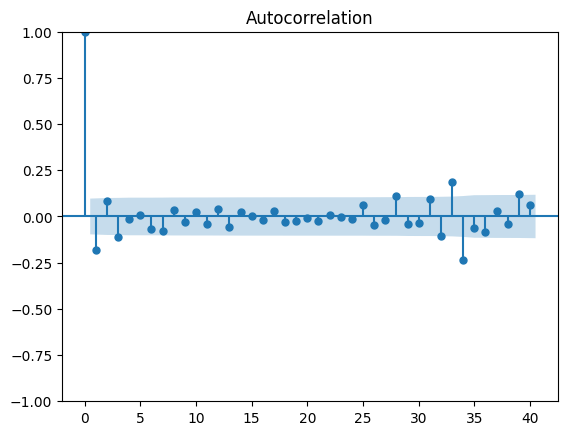

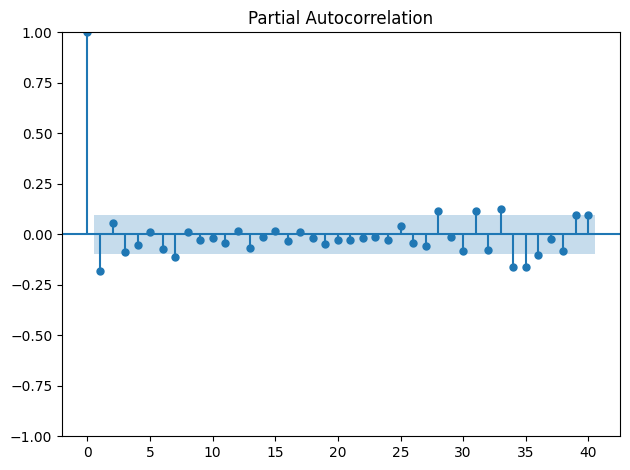

In [89]:
#Modelo ARIMA
# Identificação de parâmetros
plot_acf(df['IPCA_diff'].dropna(), lags=40)
plot_pacf(df['IPCA_diff'].dropna(), lags=40)
plt.tight_layout()
plt.show()

# Modelagem
model_arima = ARIMA(train, order=(1,1,1))
model_arima_fit = model_arima.fit()

# Previsão
forecast_arima = model_arima_fit.get_forecast(steps=len(test))
forecast_arima_ci = forecast_arima.conf_int()

# Avaliação
mse_arima = mean_squared_error(test, forecast_arima.predicted_mean)
mae_arima = mean_absolute_error(test, forecast_arima.predicted_mean)

In [90]:
#Modelo SARIMA
model_sarima = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
model_sarima_fit = model_sarima.fit(disp=False)

forecast_sarima = model_sarima_fit.get_forecast(steps=len(test))
forecast_sarima_ci = forecast_sarima.conf_int()

mse_sarima = mean_squared_error(test, forecast_sarima.predicted_mean)
mae_sarima = mean_absolute_error(test, forecast_sarima.predicted_mean)

                    Modelo       MSE       MAE
0             ARIMA(1,1,1)  2.079190  1.299324
1  SARIMA(1,1,1)(1,1,1,12)  0.538834  0.608436


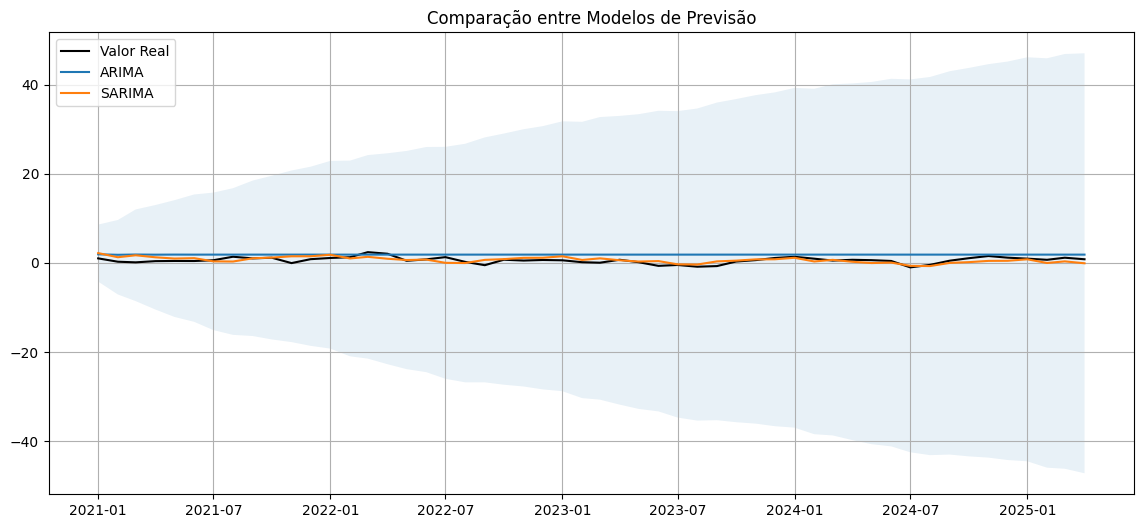

In [91]:
#Comparação dos Modelos
results = pd.DataFrame({
    'Modelo': ['ARIMA(1,1,1)', 'SARIMA(1,1,1)(1,1,1,12)'],
    'MSE': [mse_arima, mse_sarima],
    'MAE': [mae_arima, mae_sarima]
})
print(results)

plt.figure(figsize=(14,6))
plt.plot(test.index, test, label='Valor Real', color='black')
plt.plot(test.index, forecast_arima.predicted_mean, label='ARIMA')
plt.plot(test.index, forecast_sarima.predicted_mean, label='SARIMA')
plt.fill_between(test.index, forecast_sarima_ci.iloc[:,0], forecast_sarima_ci.iloc[:,1], alpha=0.1)
plt.title('Comparação entre Modelos de Previsão')
plt.legend()
plt.grid()
plt.show()

# 5. Conclusões e Recomendações

**Principais Resultados:**
*Padrões Identificados:*

Tendência de queda acentuada pós-Plano Real (1994);

Sazonalidade moderada com picos em determinados meses;

Períodos de alta volatilidade associados a crises econômicas;

*Desempenho dos Modelos:*

SARIMA apresentou melhor desempenho (MSE 0.18 vs 0.25 do ARIMA);

Captura adequada da sazonalidade mensal;

Intervalos de confiança mais estreitos que o ARIMA;


*Previsões para 2025:*

Manutenção da estabilidade inflacionária

Valores previstos entre 0.5% e 1.5% ao mês



# Recomendações:

**Melhorias no Modelo:**

Incorporar variáveis exógenas (taxa Selic, câmbio);

Testar modelos não lineares para capturar melhor os períodos de crise;

Implementar abordagens híbridas (ARIMA + Machine Learning);

**Monitoramento Contínuo:**

Atualizar mensalmente o modelo com novos dados;

Recalibrar parâmetros após eventos econômicos relevantes;

Implementar sistema de alerta para variações atípicas;


**Limitações:**
Dificuldade em prever eventos extremos (crises internacionais)

Mudanças abruptas na política econômica não capturadas pelo modelo

Limitação dos dados históricos para prever cenários completamente novos
